The fold caustic expansion to first order satisfies (https://ui.adsabs.harvard.edu/abs/1986ApJ...310..568B/abstract )

$$\tau(x_I,y_I) = \tau_0 + \tau_x x_I + \tau_y y_I\\
+\frac{1}{2!}\tau_{xx} x_I^2 + \frac{1}{2}\tau_{yy} y_I^2 + \tau_{xy}(\tau_{xx},\tau_{yy}) x_I y_I\\
+\frac{1}{3!} \tau_{xxx} x_I^2\,,$$

where the first three terms can be set to zero, without loss of generality, because (a) the overall fermat potential $\tau_0$ is not directly measurable, and (b) we can define the image-plane coordinate system such that the potential is expanded at the origin and the origin maps to the origin in the source plane (i.e., $\vec \theta_0=\vec \beta_0=\vec \theta_0-\vec \alpha_0=(0,0)$).


Here the potential is expanded at around the critical point such that $\det |\partial \vec \beta/\partial \vec \theta|=0$, which yields $\tau_{xy}(\tau_{xx},\tau_{yy})=\pm (\tau_{xx} \tau_{yy})^{1/2}$. The effective fermat potential is then

$$\tau(x_I,y_I) = \frac{1}{2!}\tau_{xx} x_I^2 + \frac{1}{2!}\tau_{yy} y_I^2 + (\tau_{xx}\tau_{yy})^{1/2} x_I y_I +\frac{1}{3!} \tau_{xxx} x_I^3\,,$$

which is equivalent to expanding the deflection potential as

$$\psi(x_I,y_I) =\frac{1}{2!}\psi_{xx} x_I^2 + \frac{1}{2!}\psi_{yy} y_I^2 + ((1-\psi_{xx})(1-\psi_{yy}))^{1/2} x_I y_I +\frac{1}{3!} \psi_{xxx} x_I^3 $$

In [1]:
import numpy as np
import jax.numpy as jnp
import jax.scipy.spatial.transform
rotation = jax.scipy.spatial.transform.Rotation
import jax
import herculens as hcl
import helens
import pylab as plt
from caustics import FoldCausticPotential, CausticExpansion, create_rotation_matrix, get_critical_lines_caustics, select_critical_point_by_angle, compute_caustic_expansion_from_macro
from grid import create_grid
import scienceplots
plt.style.use(['science','ieee'])
# Enable jax double precision:
jax.config.update('jax_enable_x64', True)

/home/user/.local/share/mamba/envs/herculens-fim-project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# LENS MASS MODEL
kwargs_lens_list = [{"theta_E": 1.0, "e1": -0.2, "e2": 0.0, "center_x": 0.0, "center_y": 0.0}]
lens_mass_model = hcl.MassModel([hcl.SIE()]) # Define the fold caustic lens

In [3]:
# GRID
xmin, xmax, ymin, ymax = -2, 2, -2, 2; nx, ny = 300, 300
pixel_grid, grid_x, grid_y, x, y = create_grid(xmin, xmax, ymin, ymax, nx, ny)
# Compute the magnifications:
mu = lens_mass_model.magnification(x, y, kwargs_lens_list)
Mu = lens_mass_model.magnification(grid_x, grid_y, kwargs_lens_list)
# Compute caustics
crit_lines, caustics = get_critical_lines_caustics(lens_mass_model, kwargs_lens_list, pixel_grid)

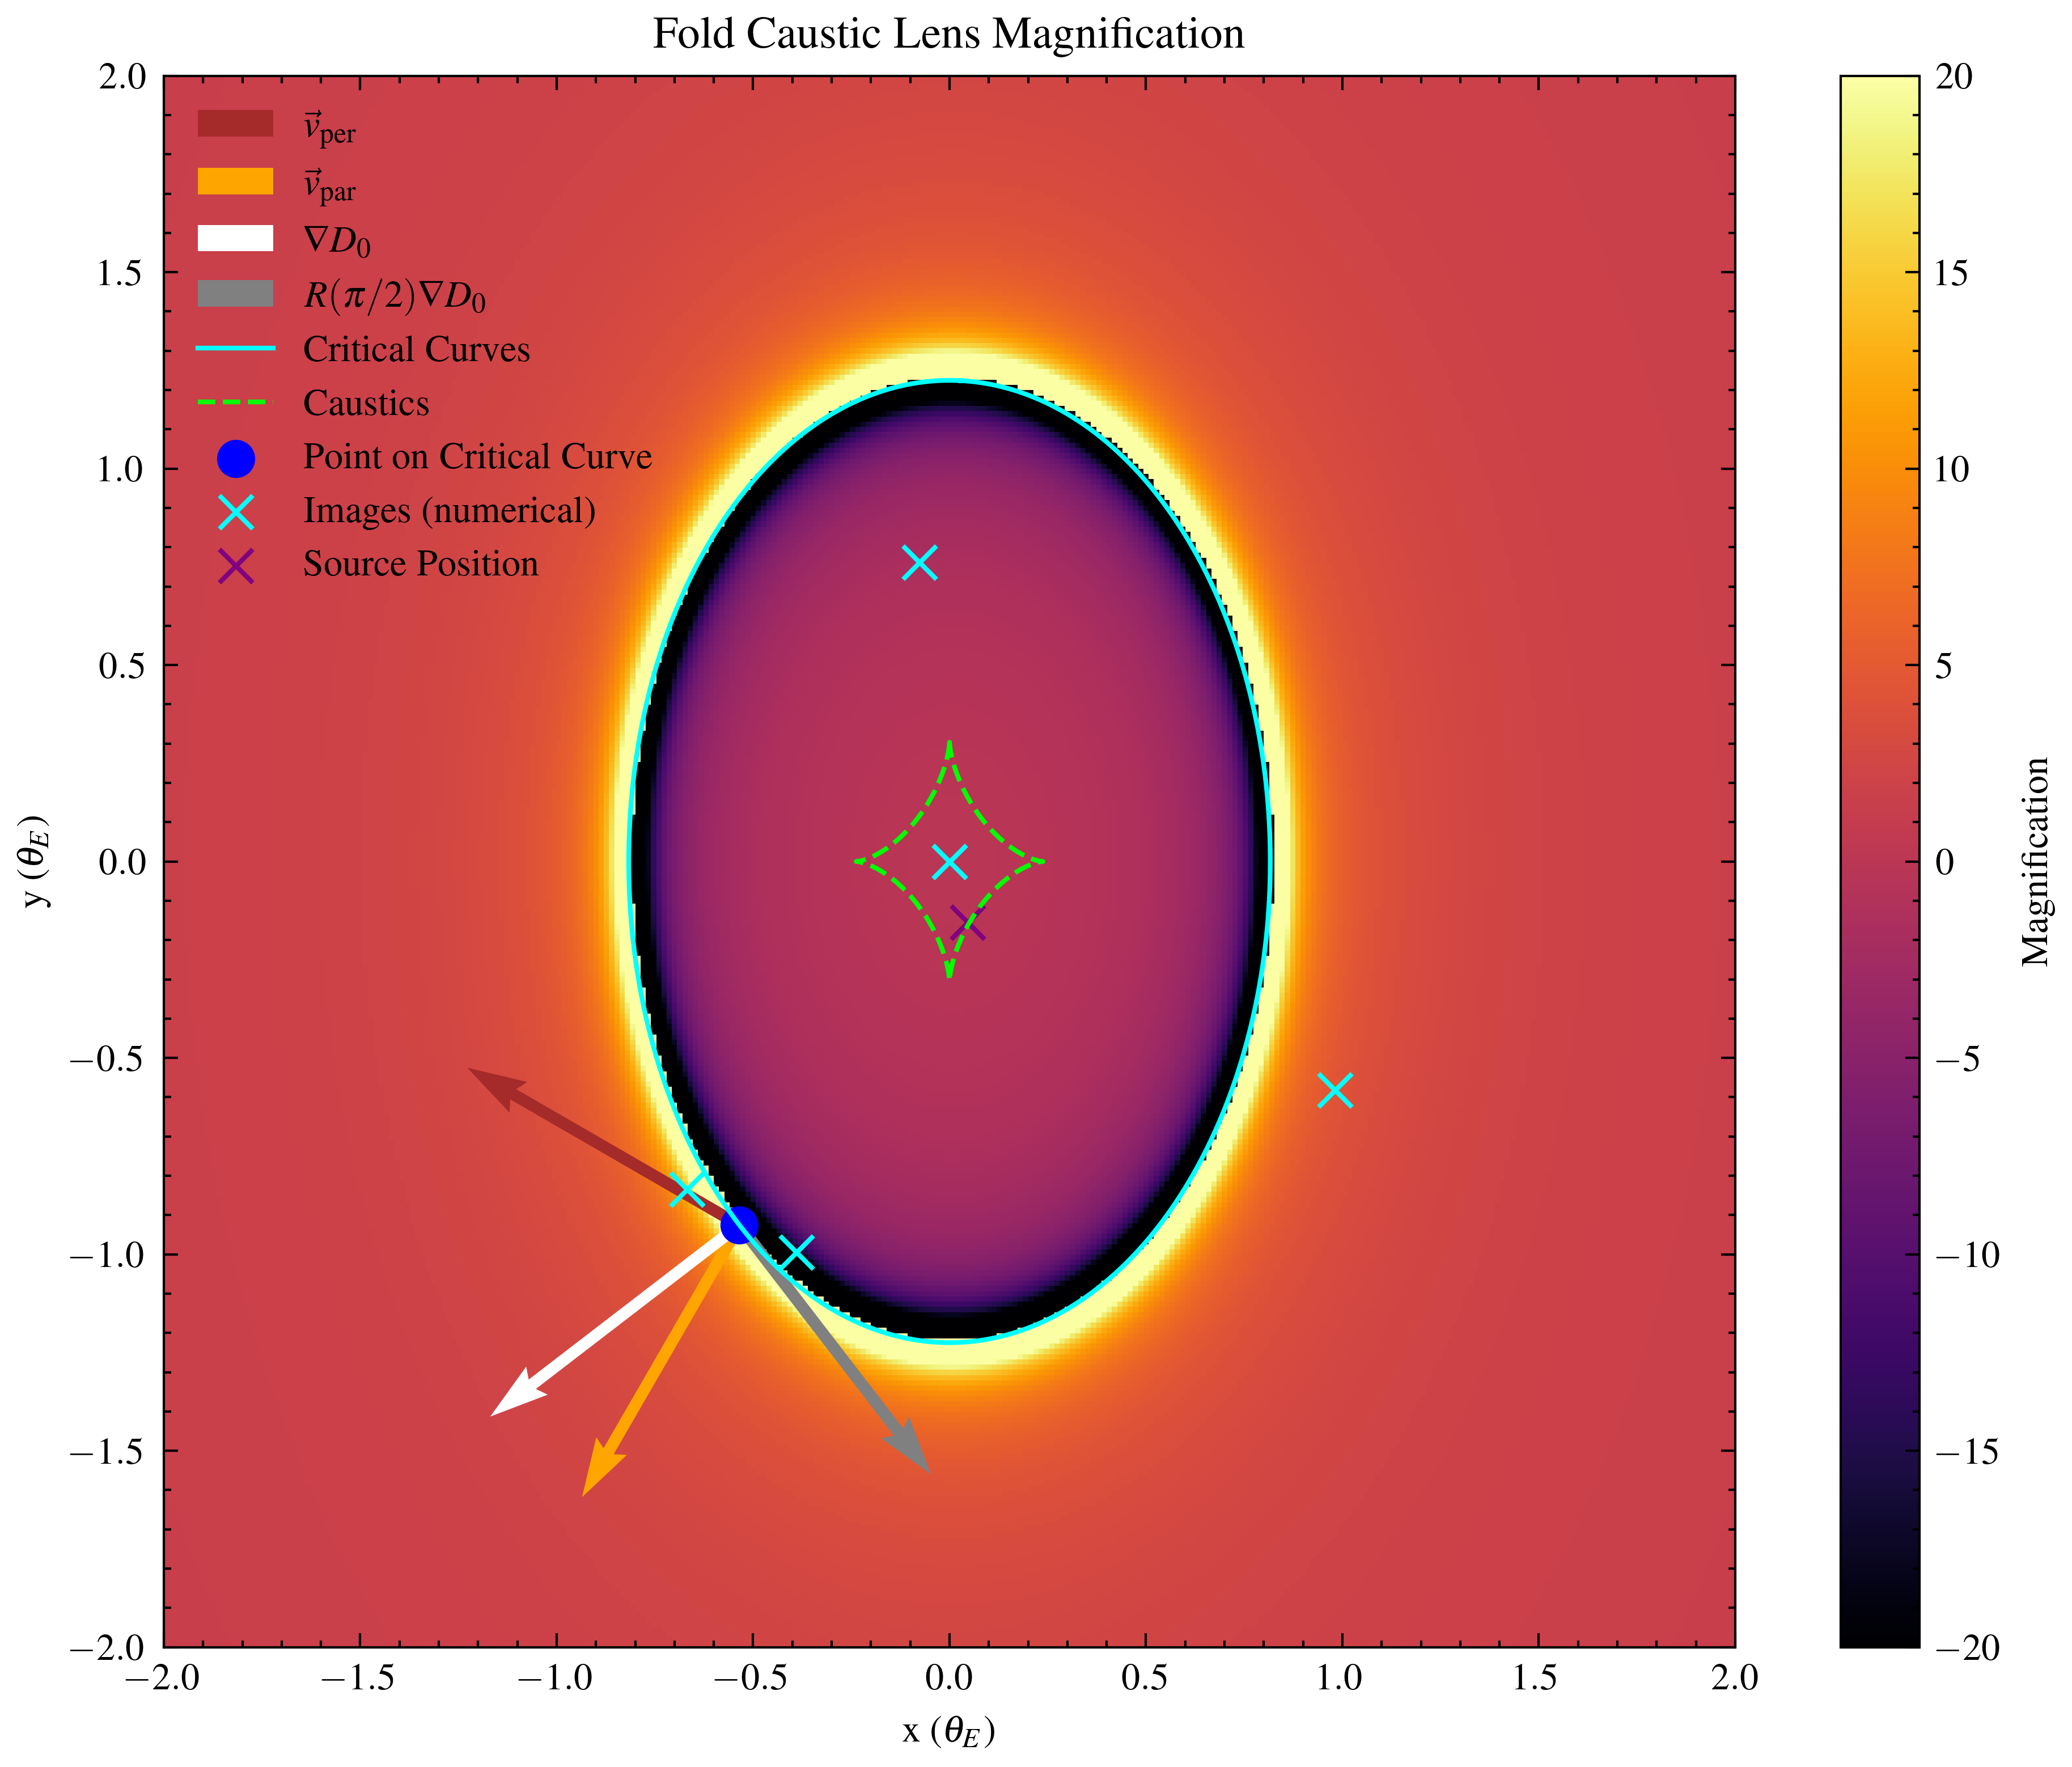

In [21]:
from plot import plot_caustic_analysis
# Make a caustic expansion at the critical curve:
rot_angle = -30-90
result = compute_caustic_expansion_from_macro(lens_mass_model, kwargs_lens_list, pixel_grid, rot_angle, solve_images=True)
# Call the function
plot_caustic_analysis(result, Mu, crit_lines, caustics, xmin, xmax, ymin, ymax)

In [ ]:
# Make a caustic expansion at the critical curve:
rot_angle = -30-90
result = compute_caustic_expansion_from_macro(lens_mass_model, kwargs_lens_list, pixel_grid, rot_angle, solve_images=True)
# Extract variables to maintain compatibility with existing code
caustic_expansion = result['caustic_expansion']
x0, y0 = result['x0'], result['y0']
v1, v2 = result['v1'], result['v2']
nabla_detA, nabla_detA_rot = result['nabla_detA'], result['nabla_detA_rot']
lambda1, lambda2 = result['lambda1'], result['lambda2']
v1_norm, v2_norm = result['v1_norm'], result['v2_norm']
v_per, v_par = result['v_per'], result['v_par']
R = result['R']
f_ij, f_ijk = result['f_ij'], result['f_ijk']
kwargs_lens_caustic_list = result['kwargs_lens_caustic_list']
lens_mass_model_caustic = result['lens_mass_model_caustic']
x_src, y_src = result['x_src'], result['y_src']
img, src = result['img'], result['src']

Array([[9.16505604e-11, 7.33367934e-07],
       [7.33367934e-07, 9.99999325e-01]], dtype=float64)

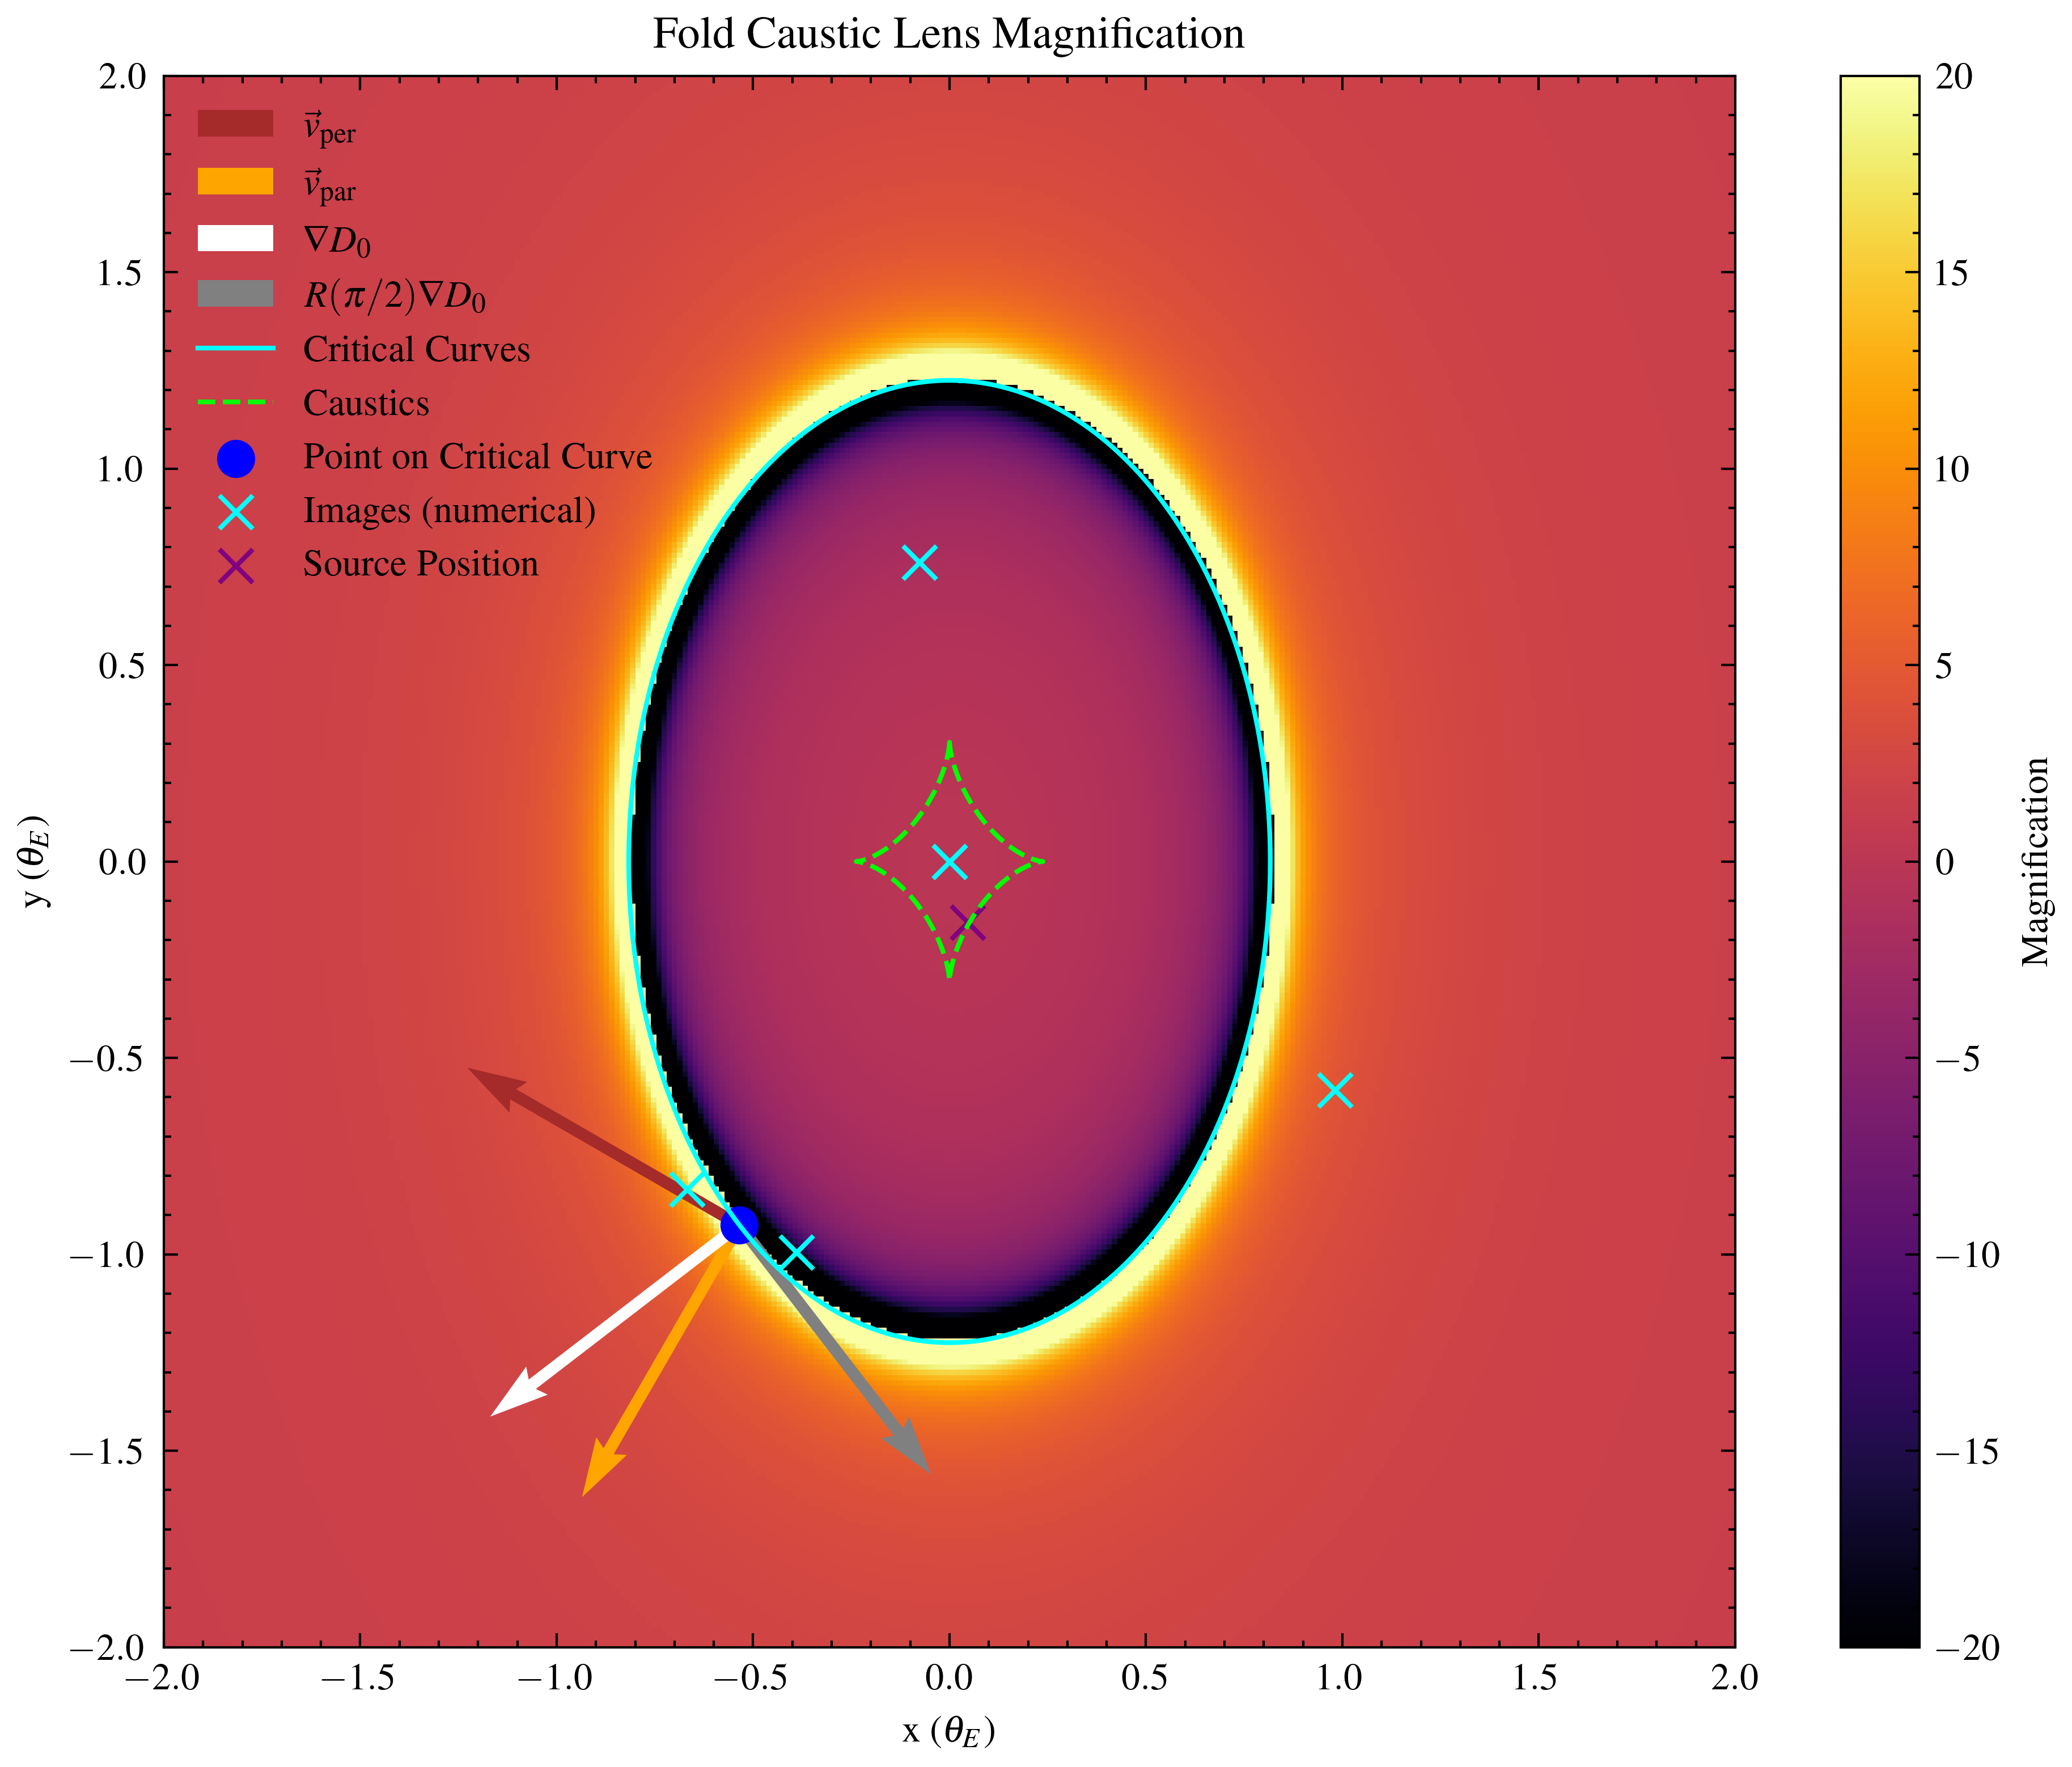

In [20]:
from plot import plot_caustic_analysis
# Make a caustic expansion at the critical curve:
rot_angle = -30-90
result = compute_caustic_expansion_from_macro(lens_mass_model, kwargs_lens_list, pixel_grid, rot_angle, solve_images=True)
# Call the function
plot_caustic_analysis(result, Mu, crit_lines, caustics, xmin, xmax, ymin, ymax)